Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Srimonti/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

[(0, 'a.jpg'), (1, 'b.jpg'), (2, 'c.jpg'), (3, 'd.jpg'), (4, 'e.jpg'), (5, 'f.jpg'), (6, 'g.jpg'), (7, 'h.jpg'), (8, 'i.jpg'), (9, 'j.jpg'), (10, 'k.jpg'), (11, 'l.jpg'), (12, '01.jpg'), (13, '02.jpg'), (14, '03.jpg'), (15, '04.jpg'), (16, '05.jpg'), (17, '06.jpg'), (18, '07.jpg'), (19, '08.jpg'), (20, '09.jpg'), (21, '10.jpg'), (22, '11.jpg'), (23, '12.jpg'), (24, '13.jpg'), (25, '14.jpg'), (26, '15.jpg'), (27, '16.jpg'), (28, '17.jpg'), (29, '18.jpg')]
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


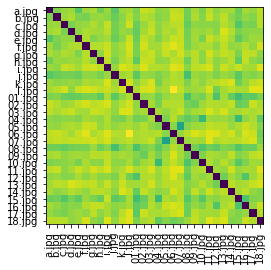

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
import os.path
from hard_triplet_loss import HardTripletLoss, _pairwise_distance
from netvlad import EmbedNet
from netvlad import NetVLAD


class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        # this is what ImageFolder normally returns
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        name = os.path.split(self.imgs[index][0])[-1]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (name,))
        return tuple_with_path


# Discard layers at the end of base network
encoder = resnet18(pretrained=True)
base_model = nn.Sequential(
    encoder.conv1,
    encoder.bn1,
    encoder.relu,
    encoder.maxpool,
    encoder.layer1,
    encoder.layer2,
    encoder.layer3,
    encoder.layer4,
)
dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

# Define model for embedding
net_vlad = NetVLAD(num_clusters=32, dim=dim, alpha=1.0)
# noinspection PyUnresolvedReferences
model = EmbedNet(base_model, net_vlad).cuda()

# Define loss
# noinspection PyUnresolvedReferences
criterion = HardTripletLoss(margin=0.1).cuda()

preprocess = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])

train_dataset = ImageFolderWithPaths(
        root='data/',
        transform=preprocess
    )
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
)

x, labels, fn = iter(train_loader).next()
print(list(enumerate(fn)))
x = x.cuda()
labels = labels.long()
output = model(x)

print(labels)


triplet_loss = criterion(output, labels)
plt.imshow(_pairwise_distance(output).cpu().detach().numpy())
plt.gca().set_xticks(list(range(30)))
plt.gca().set_yticks(list(range(30)))

plt.gca().set_xticklabels(fn, rotation='vertical')
plt.gca().set_yticklabels(fn)

plt.show()